<a href="https://colab.research.google.com/github/revy1817/NLP_BG/blob/less_1_hw/HomeWork_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymorphy2 pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=1c7c6b3c05f116ff37c02ff856913b87eed70922626a24fac94fc62a8e053439
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
import pandas as pd
import numpy as np
import re

import pymorphy2
import nltk

from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool
from pymystem3 import Mystem

from gensim.models import *
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('stopwords')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
positive_path = '/content/drive/MyDrive/Colab Notebooks/Учеба/GeekBrains/Введение в обработку естественного языка/less 2/positive.csv'
negative_path = '/content/drive/MyDrive/Colab Notebooks/Учеба/GeekBrains/Введение в обработку естественного языка/less 2/negative.csv'

In [ ]:
positive = pd.read_csv(positive_path, sep=';', usecols=[3], names=['text'])
negative = pd.read_csv(negative_path, sep=';', usecols=[3], names=['text'])
df = positive.append(negative)

In [ ]:
df

text
0       @first_timee хоть я и школота, но поверь, у на...
1       Да, все-таки он немного похож на него. Но мой ...
2       RT @KatiaCheh: Ну ты идиотка) я испугалась за ...
3       RT @digger2912: "Кто то в углу сидит и погибае...
4       @irina_dyshkant Вот что значит страшилка :D\nН...
...                                                   ...
111918  Но не каждый хочет что то исправлять:( http://...
111919  скучаю так :-( только @taaannyaaa вправляет мо...
111920          Вот и в школу, в говно это идти уже надо(
111921  RT @_Them__: @LisaBeroud Тауриэль, не грусти :...
111922  Такси везет меня на работу. Раздумываю приплат...

[226834 rows x 1 columns]

In [ ]:
morph = pymorphy2.MorphAnalyzer()
stopwords_list = stopwords.words('russian')
words_regex = re.compile('\w+')

In [ ]:
def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]



def lemmatize(words, stopwords, lemmer = morph):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text, stopwords):
    return (lemmatize(find_words(text), stopwords))

In [ ]:
df['text'] = df['text'].apply(preprocess)

In [ ]:
df.head(5)

text
0  [школотый, поверь, самый, общество, профилиров...
1  [всё, таки, немного, похожий, мальчик, всё, ра...
2                   [katiacheh, идиотка, испугаться]
3  [угол, сидеть, погибать, голод, ещё, порция, в...
4  [значит, страшилка, блин, посмотреть, всё, час...

In [ ]:
len(df)

226834

In [ ]:
dictionary = corpora.Dictionary(df['text'])

dictionary.filter_extremes(no_below = 20, no_above = 0.6, keep_n=None) # игнорируем слова, которые встречаются реже 20 раз или составляют более 0.6 словаря 
dictionary.save('tweet.dict')

In [ ]:
corpus = [dictionary.doc2bow(text) for text in df['text']]
corpora.MmCorpus.serialize('tweet.model', corpus) 

In [ ]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=25, chunksize=50, update_every=1, passes=2)

CPU times: user 13min 12s, sys: 6.37 s, total: 13min 18s
Wall time: 13min 19s


In [ ]:
%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: user 18.5 s, sys: 267 ms, total: 18.8 s
Wall time: 26.5 s


In [ ]:
coherence_model_lda = CoherenceModel(model=lda, texts=df['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.29032651433243695


Как видно из ошибки и визуального распределения, результаты очень плохие, большинство тем накладываются друг на друга, а слова не относятся к распределению тематик

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 2min 30s, sys: 1.57 s, total: 2min 32s
Wall time: 2min 31s
CPU times: user 3min 28s, sys: 2.76 s, total: 3min 31s
Wall time: 3min 30s
CPU times: user 4min 38s, sys: 3.41 s, total: 4min 42s
Wall time: 4min 41s
CPU times: user 5min 48s, sys: 2.92 s, total: 5min 50s
Wall time: 5min 50s
CPU times: user 6min 55s, sys: 9.28 s, total: 7min 4s
Wall time: 7min 3s


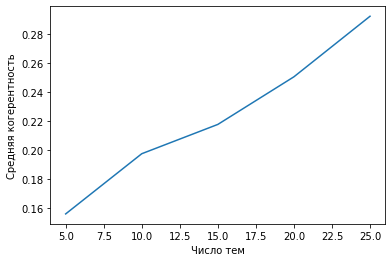

In [ ]:
# Попробуем провести перебор по количеству тематик и посмотрим на результат
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    %time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherence_model_lda = CoherenceModel(model=lda, texts=df['text'], dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherences.append(coherence_lda)

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

С увелечением кол-во тем растет и результат

In [ ]:
# Попробуем выбрать слова которые не должны нести смысла при описании тематики разговора, такие как как это или http, постепенно на каждом этапе обучения слова будут дополняться

stopwords_user = ['спать', 'жаль', 'очень', 'делать', 'сегодня', 'мочь', 'собираться', 
                  'дать', 'чувствовать', 'пздца', 'поставить', 'каждый','обидно', 'весь', 
                  'вообще', 'amp', 'никак', 'нечего', 'зато', 'начать', 'всё', 
                  'прям', 'смысл', 'пока', 'жалко', 'блядь', 'пройти', 'увидеть', 
                  'который', 'понимать', 'снова', 'вроде', 'пожалуйста', 'ага', 
                  'твой', 'вставать', 'прийтись', 'получиться', 'хотеть', 'хотя', 
                  'видеть', 'почему', 'таки', 'ещё', 'сука', 'взять', 'ладный', 
                  'это', 'наверное', 'настолько', 'поэтому', 'http', 'день', 'завтра', 'блин', 
                  'хотеться', 'знать', 'свой', 'большой', 'просто', 'писать', 
                  'смотреть', 'хороший', 'сказать', 'идти', 'скучать', 'пойти', 
                  'думать', 'самый', 'говорить', 'сать', 'ждать', 'смочь', 'туда', 
                  'забыть', 'нибыть', 'бля', 'написать', 'прийти', 'вчера', 'равно', 
                  'ппц', 'фак', 'напомнить', 'быстро', 'верить', 'оставаться', 
                  'сучка', 'ахи']

In [ ]:
df['text'] = df['text'].apply(preprocess_ver_2)

In [ ]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=25, chunksize=50, update_every=1, passes=6)

coherence_model_lda = CoherenceModel(model=lda, texts=df['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

CPU times: user 13min 31s, sys: 12.5 s, total: 13min 44s
Wall time: 13min 44s
Средняя когерентность:  0.3892583869803676


Как видно из результатов, удаление слов не имеющих тематической окрашенности дает серьезный большой рост к результатам

In [ ]:
%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: user 25.6 s, sys: 241 ms, total: 25.9 s
Wall time: 37.8 s


Как видно из визуализации наших кластеров, визуально стало намного лучше, каждый кластер имеет близкие, но почти не пересекающийся границы, также из общего списка самых важных слов видим множество слов которые не могут описывать тематику, добавим их в словарь

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 12min 42s, sys: 5.88 s, total: 12min 48s
Wall time: 12min 47s
CPU times: user 16min 53s, sys: 5.4 s, total: 16min 58s
Wall time: 16min 58s


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 17min 42s, sys: 5.5 s, total: 17min 47s
Wall time: 17min 47s


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 16min 43s, sys: 5.81 s, total: 16min 49s
Wall time: 16min 56s


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 18min 6s, sys: 5.71 s, total: 18min 12s
Wall time: 18min 13s


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 19min 45s, sys: 5.96 s, total: 19min 51s
Wall time: 19min 51s


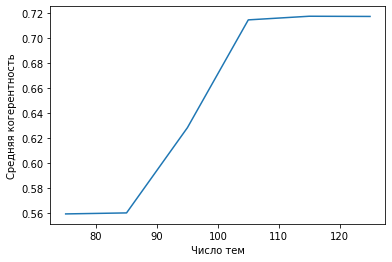

In [ ]:
# Попробуем экспоненциально увеличивать кол-во кластеров
topics_list = [75, 85, 95, 105, 115, 125]
coherences = []

for num in tqdm(topics_list):
    %time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherence_model_lda = CoherenceModel(model=lda, texts=df['text'], dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherences.append(coherence_lda)

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

Как видно из результата увеленчение кол-во тематик привело к очень хорошей когерентности, а между 80 и 100 начинается резкий рост, построим модель со 125 тематиками и посмотрим поближе

In [ ]:
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=125, chunksize=50, update_every=1, passes=6)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [ ]:
coherence_model_lda = CoherenceModel(model=lda, texts=df['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.7177615294744862


In [ ]:
%time vis_data = gensimvis.prepare(lda, corpus, dictionary, mds='mmds')
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: user 25.9 s, sys: 726 ms, total: 26.6 s
Wall time: 34.8 s


Визуально все не плохо, но многих тематик нет, так как они имеют 0 вес, а также если расмотреть тематики поближе то все очень плохо, тематику может опредлеять одно слово, например "хахахаха" или "похуй", пройдемся по тематикам и удалим лишние слова

In [ ]:
# Посмотрим на модель с 70 тематиками и обновленным словорем стоп слов
%time lda_2 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=70, chunksize=50, update_every=1, passes=6)

coherence_model_lda_2 = CoherenceModel(model=lda_2, texts=df['text'], dictionary=dictionary, coherence='c_v')
coherence_lda_2 = coherence_model_lda_2.get_coherence()
print('Средняя когерентность: ', coherence_lda_2)

Средняя когерентность:  0.5302567063068305


In [ ]:
%time vis_data = gensimvis.prepare(lda_2, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: user 18.6 s, sys: 267 ms, total: 18.9 s
Wall time: 22.9 s


Луче чем было со 125 тематиками и 25 ранее, слов которые определяеют тематику много, но в целом все также плохо, тематики наслаиваются друг на друга а также имеется множество не важных слов, пройдемся и обновим словарь

Нашел в разных проектах с LDA использование кастомных словарей стоп слов на русском языке, попробуем их импортировать, объединить с дефолтным словарем и созданным мной ранее при обучении и посмотрим на результат

In [ ]:
custom_stopwords_1 = ["c","а","алло","без","белый","близко","более","больше","большой","будем","будет","будете","будешь","будто","буду","будут","будь","бы","бывает","бывь","был","была","были","было","быть","в","важная","важное","важные","важный","вам","вами","вас","ваш","ваша","ваше","ваши","вверх","вдали","вдруг","ведь","везде","вернуться","весь","вечер","взгляд","взять","вид","видел","видеть","вместе","вне","вниз","внизу","во","вода","война","вокруг","вон","вообще","вопрос","восемнадцатый","восемнадцать","восемь","восьмой","вот","впрочем","времени","время","все","все еще","всегда","всего","всем","всеми","всему","всех","всею","всю","всюду","вся","всё","второй","вы","выйти","г","где","главный","глаз","говорил","говорит","говорить","год","года","году","голова","голос","город","да","давать","давно","даже","далекий","далеко","дальше","даром","дать","два","двадцатый","двадцать","две","двенадцатый","двенадцать","дверь","двух","девятнадцатый","девятнадцать","девятый","девять","действительно","дел","делал","делать","делаю","дело","день","деньги","десятый","десять","для","до","довольно","долго","должен","должно","должный","дом","дорога","друг","другая","другие","других","друго","другое","другой","думать","душа","е","его","ее","ей","ему","если","есть","еще","ещё","ею","её","ж","ждать","же","жена","женщина","жизнь","жить","за","занят","занята","занято","заняты","затем","зато","зачем","здесь","земля","знать","значит","значить","и","иди","идти","из","или","им","имеет","имел","именно","иметь","ими","имя","иногда","их","к","каждая","каждое","каждые","каждый","кажется","казаться","как","какая","какой","кем","книга","когда","кого","ком","комната","кому","конец","конечно","которая","которого","которой","которые","который","которых","кроме","кругом","кто","куда","лежать","лет","ли","лицо","лишь","лучше","любить","люди","м","маленький","мало","мать","машина","между","меля","менее","меньше","меня","место","миллионов","мимо","минута","мир","мира","мне","много","многочисленная","многочисленное","многочисленные","многочисленный","мной","мною","мог","могу","могут","мож","может","может быть","можно","можхо","мои","мой","мор","москва","мочь","моя","моё","мы","на","наверху","над","надо","назад","наиболее","найти","наконец","нам","нами","народ","нас","начала","начать","наш","наша","наше","наши","не","него","недавно","недалеко","нее","ней","некоторый","нельзя","нем","немного","нему","непрерывно","нередко","несколько","нет","нею","неё","ни","нибудь","ниже","низко","никакой","никогда","никто","никуда","ним","ними","них","ничего","ничто","но","новый","нога","ночь","ну","нужно","нужный","нх","о","об","оба","обычно","один","одиннадцатый","одиннадцать","однажды","однако","одного","одной","оказаться","окно","около","он","она","они","оно","опять","особенно","остаться","от","ответить","отец","откуда","отовсюду","отсюда","очень","первый","перед","писать","плечо","по","под","подойди","подумать","пожалуйста","позже","пойти","пока","пол","получить","помнить","понимать","понять","пор","пора","после","последний","посмотреть","посреди","потом","потому","почему","почти","правда","прекрасно","при","про","просто","против","процентов","путь","пятнадцатый","пятнадцать","пятый","пять","работа","работать","раз","разве","рано","раньше","ребенок","решить","россия","рука","русский","ряд","рядом","с","с кем","сам","сама","сами","самим","самими","самих","само","самого","самой","самом","самому","саму","самый","свет","свое","своего","своей","свои","своих","свой","свою","сделать","сеаой","себе","себя","сегодня","седьмой","сейчас","семнадцатый","семнадцать","семь","сидеть","сила","сих","сказал","сказала","сказать","сколько","слишком","слово","случай","смотреть","сначала","снова","со","собой","собою","советский","совсем","спасибо","спросить","сразу","стал","старый","стать","стол","сторона","стоять","страна","суть","считать","т","та","так","такая","также","таки","такие","такое","такой","там","твои","твой","твоя","твоё","те","тебе","тебя","тем","теми","теперь","тех","то","тобой","тобою","товарищ","тогда","того","тоже","только","том","тому","тот","тою","третий","три","тринадцатый","тринадцать","ту","туда","тут","ты","тысяч","у","увидеть","уж","уже","улица","уметь","утро","хороший","хорошо","хотел бы","хотеть","хоть","хотя","хочешь","час","часто","часть","чаще","чего","человек","чем","чему","через","четвертый","четыре","четырнадцатый","четырнадцать","что","чтоб","чтобы","чуть","шестнадцатый","шестнадцать","шестой","шесть","эта","эти","этим","этими","этих","это","этого","этой","этом","этому","этот","эту","я","являюсь"]

with open("/content/drive/MyDrive/Colab Notebooks/Учеба/GeekBrains/Введение в обработку естественного языка/Less 4/RussianStopWords.txt", "r", encoding="utf-8") as file:

    custom_stopwords_2 = file.read().split('\n')

custom_stopwords = custom_stopwords_1 + custom_stopwords_2 + stopwords_list + stopwords_user

In [ ]:
df['text'] = df['text'].apply(preprocess, stopwords=custom_stopwords)

In [ ]:
%time lda_2 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=70, chunksize=250, update_every=1, passes=12)

coherence_model_lda_2 = CoherenceModel(model=lda_2, texts=df['text'], dictionary=dictionary, coherence='c_v')
coherence_lda_2 = coherence_model_lda_2.get_coherence()
print('Средняя когерентность: ', coherence_lda_2)

CPU times: user 18min 48s, sys: 17.2 s, total: 19min 5s
Wall time: 19min 2s
Средняя когерентность:  0.582073547285242


In [ ]:
%time vis_data = gensimvis.prepare(lda_2, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: user 30.8 s, sys: 345 ms, total: 31.1 s
Wall time: 43.4 s


Как видно когерентность сильно выросла на тех же 70 тематиках, но визуально все также плохо, плюс много лишних слов имеют большие веса, обновим словарь, и попробуем увелечить тематики до 100

In [ ]:
%time lda_150 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=150, chunksize=250, update_every=1, passes=12)

coherence_model_lda_150 = CoherenceModel(model=lda_150, texts=df['text'], dictionary=dictionary, coherence='c_v')
coherence_lda_150 = coherence_model_lda_150.get_coherence()
print('Средняя когерентность: ', coherence_lda_150)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 34min 19s, sys: 11 s, total: 34min 30s
Wall time: 34min 28s
Средняя когерентность:  0.6880793767374092


In [ ]:
%time vis_data = gensimvis.prepare(lda_150, corpus, dictionary, mds='mmds')
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: user 29.8 s, sys: 249 ms, total: 30 s
Wall time: 36.8 s


Визуально все идеально, тематик много, все слова хорошо распределены и  имеют средний центр около 0, если пройтись по тематикам то уже можно выделять из них тему разговора, например тематика № 45 имеют общею тему выпивки, тематика №7 описывает тему счастья или радости, тематика № 10 описывает тему с посещением чего либо, но в целом все также слишком много лишних слов, причем эти лишние слова могут описывать целую тему, например тематика №121 только слово "шта" имеет вес и определяет целую тематику, в целом таких слов очень много, и если делать обучение и на каждом этапе добавлять новые лишние слова то можно довести эту модель до почти идеального разбиения текста на тематики